In [0]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 100

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(x_train.shape)
print(y_train.shape)

Using TensorFlow backend.


11493376/11490434 [==============================] - 2s 0us/step
(60000, 28, 28, 1)
(60000, 10)


In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])



In [0]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=30,
          verbose=1,
          validation_data=(x_test, y_test))


No handles with labels found to put in legend.


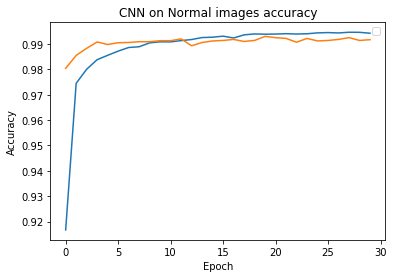

In [0]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('CNN on Normal images accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

In [0]:
pred = model.predict(x_test)


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
import math
from skimage.metrics import structural_similarity as ssim

input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [0]:
autoencoder.load_weights('/content/gdrive/My Drive/Colab Notebooks/checks_autoencoder/model-100.hdf5')

In [0]:
x_train_cnn = autoencoder.predict(x_train.reshape(60000,784))
x_test_cnn = autoencoder.predict(x_test.reshape(10000,784))

In [0]:
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes, activation='softmax'))

model2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])



In [0]:
model2.fit(x_train_cnn.reshape(60000,28,28,1), y_train,
          batch_size=batch_size,
          epochs=30,
          verbose=1,
          validation_data=(x_test_cnn.reshape(10000,28,28,1), y_test))


No handles with labels found to put in legend.


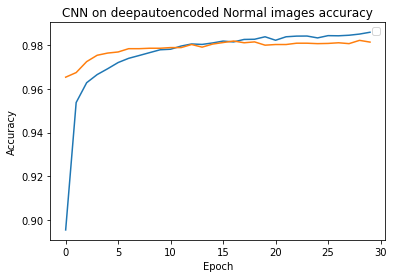

In [0]:
# Plot training & validation accuracy values
plt.plot(model2.history.history['acc'])
plt.plot(model2.history.history['val_acc'])
plt.title('CNN on deepautoencoded Normal images accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()


Add noise to MNIST dataset

In [0]:
import numpy as np
import os
import cv2

In [0]:
def noisy(noise_typ,image):
  if noise_typ == "gauss":
    row,col,ch= image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return noisy
  elif noise_typ == "s&p":
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    out[coords] = 1
    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    out[coords] = 0
    return out

  elif noise_typ == "poisson":
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy = np.random.poisson(image * vals) / float(vals)
    return noisy
  elif noise_typ =="speckle":
    row,col,ch = image.shape
    gauss = np.random.randn(row,col,ch)
    gauss = gauss.reshape(row,col,ch)        
    noisy = image + image * gauss
    return noisy


In [0]:
def prepare_data(data,noise):
  output = np.zeros(data.shape)
  for i in range(len(data)):
    output[i]=noisy(noise,data[i])
  return output

Exemple 1: Gaussian noise

In [0]:
noise='gauss'
x_train_gauss=prepare_data(x_train,noise)
x_test_gauss=prepare_data(x_test,noise)

IF we train our model with normal noisy dataset

In [0]:
model3 = Sequential()
model3.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(num_classes, activation='softmax'))

model3.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model3.fit(x_train_gauss.reshape(60000,28,28,1), y_train,
          batch_size=batch_size,
          epochs=30,
          verbose=1,
          validation_data=(x_test_gauss.reshape(10000,28,28,1), y_test))

No handles with labels found to put in legend.


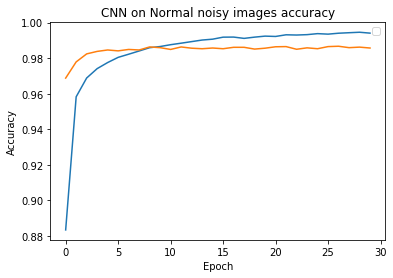

In [0]:
# Plot training & validation accuracy values
plt.plot(model3.history.history['acc'])
plt.plot(model3.history.history['val_acc'])
plt.title('CNN on Normal noisy images accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

Npw we apply CNN on deep noisy autoencoded images

In [0]:
x_train_cnn_on_noisy = autoencoder.predict(x_train_gauss.reshape(60000,784))
x_test_cnn_on_noisy = autoencoder.predict(x_test_gauss.reshape(10000,784))

In [0]:
model4 = Sequential()
model4.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model4.add(Conv2D(64, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))
model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(num_classes, activation='softmax'))

model4.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [0]:
model4.fit(x_train_cnn_on_noisy.reshape(60000,28,28,1), y_train,
          batch_size=batch_size,
          epochs=30,
        verbose=1,
          validation_data=(x_test_cnn_on_noisy.reshape(10000,28,28,1), y_test))

No handles with labels found to put in legend.


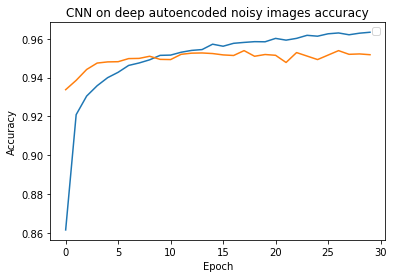

In [0]:
# Plot training & validation accuracy values
plt.plot(model4.history.history['acc'])
plt.plot(model4.history.history['val_acc'])
plt.title('CNN on deep autoencoded noisy images accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()